# Automation of CMV Detection for Large Time Series

When applying the field analysis methodology, there is often an extensive dataset available showing, e.g. time series data for a plant over the course of an entire year or longer. In order to apply the method, it is necessary to obtain reduce the CMVs to a subset for which the method can be applied, because simply calculating for every possible cloud motion vector pair is computationally intractable. 

This notebook will demonstrate the process for downselecting a set of interesting CMVs according to the methodology discussed in the 2024 IEEE PVSC paper.


## Initialization
First we need to import relevant packages. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib

from solartoolbox import stats, spatial, cmv

## The Data
For this example, we will work on four days of 10s resolution data from the HOPE Melpitz campaign, included in the sample data package. We'll first read it in. Since the CMV routine is built to work on the clearsky index, we'll calculate that while we're at it. The plot shows a sample of the data for a single sensor over the four days. 

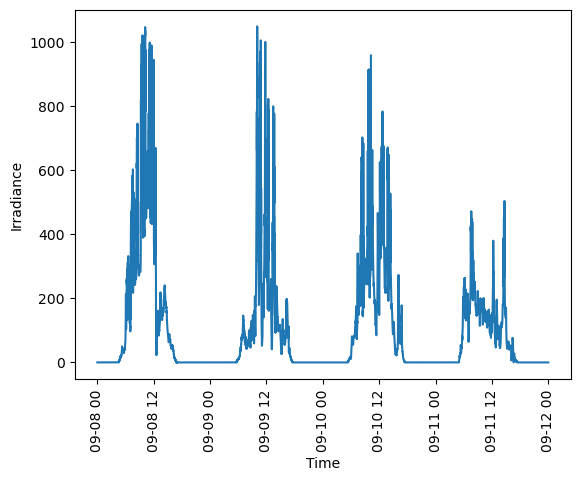

In [2]:
fn = 'data/hope_melpitz_10s.h5'
pos = pd.read_hdf(fn, mode="r", key="latlon")
pos_utm = spatial.latlon2utm(pos['lat'], pos['lon'])
ts_data = pd.read_hdf(fn, mode="r", key="data")

loc = pvlib.location.Location(np.mean(pos['lat']), np.mean(pos['lon']))
cs_ghi = loc.get_clearsky(ts_data.index, model='simplified_solis')['ghi']
kt = ts_data.divide(cs_ghi, axis=0).clip(0,2)

# Plot a single sensor's data
plt.plot(ts_data.index, ts_data[40])
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Irradiance')
plt.show()

## Deciding which Periods to Calculate CMVs For
I typically calculate CMVs using a one hour period of data. While that's viable for the whole four days here, it would rapidly become ornerous over e.g. an entire year, due to the computational intensity of the CMV method. One method to reduce the number of CMVs to calculate is to only calculate them for periods where the irradiance is changing rapidly, indicating the presence of clouds. Here we will use the Variability Score to quantify how variable each one hour period is in the data. 

Note that the variability score calculation has a slightly weird form using lambda functions, because doing so can allow the calculation to be performed using the vectorized form of the code. Other techniques might be possible.  

C:\Users\jar339\AppData\Local\Temp\ipykernel_17088\1689254596.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: stats.variability_score(x[ts_data.columns]))


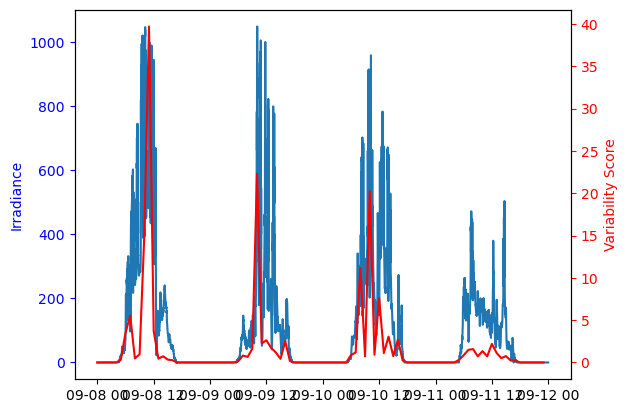

In [6]:
avg_interval = '1h'

# Calc the VS for each 1 hour period
vs_all = ts_data.resample(avg_interval).apply(
                lambda x: stats.variability_score(x[ts_data.columns]))

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(ts_data.index, ts_data[40])
plt.xlabel('Time')
plt.xticks(rotation=90)
ax.set_ylabel('Irradiance', color='blue')
ax.tick_params(axis='y', colors='blue')
ax2.plot(vs_all.index, vs_all[40], 'r')
ax2.set_ylabel('Variability Score', color='red')
ax2.tick_params(axis='y', colors='red')
plt.show()

Once we have a metric of variability, we can downselect to retain only the N most variable periods. Here we'll use 20 just as an example.

In [7]:
n_var = 20
vs = vs_all.median(axis=1).sort_values(ascending=False)
vs = vs.iloc[0:n_var]
print(vs)

2013-09-08 11:00:00+00:00    36.827512
2013-09-10 10:00:00+00:00    17.346362
2013-09-09 10:00:00+00:00    16.861423
2013-09-08 10:00:00+00:00    14.032438
2013-09-10 08:00:00+00:00    11.659271
2013-09-10 12:00:00+00:00     7.277602
2013-09-08 07:00:00+00:00     4.998409
2013-09-10 14:00:00+00:00     3.878509
2013-09-08 06:00:00+00:00     3.846806
2013-09-08 12:00:00+00:00     3.722167
2013-09-09 12:00:00+00:00     3.016234
2013-09-09 16:00:00+00:00     2.515403
2013-09-10 16:00:00+00:00     2.369758
2013-09-11 12:00:00+00:00     2.250612
2013-09-09 11:00:00+00:00     2.169986
2013-09-11 08:00:00+00:00     1.778225
2013-09-09 13:00:00+00:00     1.750230
2013-09-09 09:00:00+00:00     1.719327
2013-09-10 13:00:00+00:00     1.264782
2013-09-08 09:00:00+00:00     1.185312
dtype: float64


## Calculating the CMVs
Now that we have a set of periods during which to calculate the CMV, we can loop over them to do the calculations. We also want to record some of the useful statistical and quality control information about the quality of the CMVs, because we'd later like to be able to determine which of these are of high quailty.

We will assess the CMVs based on the following values:
- `ngood` - the number of point pairs that passed the Jamaly QC routines
- `r_corr` - the correlation coefficient of separation vs. delay for the good point pairs (see cmv_demo.ipynb).  
- `flag` - the overall flag from the CMV QC process

In [8]:
cmvs = pd.DataFrame(columns=["cld_spd", "cld_dir_rad", "df_p95", "ngood", "r_corr", "stderr_corr", "error_index", "flag"])
for date in vs.index:
    # Select the subset of data
    hour = pd.date_range(date, date + pd.to_timedelta('1h'), freq='10s')
    kt_hour = kt.loc[hour]
    
    hourlymax = ts_data.loc[hour].max().quantile(0.95)

    # Compute the CMV using the Jamaly method
    cld_spd, cld_dir, dat = cmv.compute_cmv(kt_hour, pos_utm, method='jamaly', options={'minvelocity': 1})

    cmvs.loc[date] = [cld_spd, cld_dir, hourlymax, dat.method_data['ngood'], dat.method_data['r_corr'], dat.method_data['stderr_corr'], np.abs(dat.method_data["error_index"]), dat.flag.name]
pd.options.display.width = 800
print(cmvs)

                             cld_spd  cld_dir_rad       df_p95  ngood    r_corr  stderr_corr  error_index  flag
2013-09-08 11:00:00+00:00  17.253624     1.015742  1036.323712    306  0.990169     0.147371     0.102980  GOOD
2013-09-10 10:00:00+00:00   9.323374     0.446288   967.214252    624  0.970793     0.090337     0.128893  GOOD
2013-09-09 10:00:00+00:00  12.315270     5.789374  1105.664569    467  0.951945     0.197357     0.175704  GOOD
2013-09-08 10:00:00+00:00  15.790708     1.022334  1070.301172    781  0.872326     0.190603     0.202564  GOOD
2013-09-10 08:00:00+00:00  13.386957     0.736245   752.929056    581  0.989464     0.080910     0.082828  GOOD
2013-09-10 12:00:00+00:00  27.468773     0.515227   839.723816    412  0.978562     0.275288     0.122317  GOOD
2013-09-08 07:00:00+00:00  18.609486     0.871618   642.030344    797  0.992215     0.084133     0.081098  GOOD
2013-09-10 14:00:00+00:00  13.931439     0.698200   657.489758    756  0.943971     0.168528     0.19547

# Downselect to High Quality CMVs
We can now downselect to only the highest quality CMVs. The limits shown here are just for reference based off this dataset. They probably need to be tuned to each specific dataset to appropriately limit the CMVs. The printout shows the ones that failed the QC.

In [9]:
ngood_min = 200
rval_min = 0.85
bad_inds = []
for row in cmvs.itertuples():
    if row.ngood < ngood_min:
        bad_inds.append(row.Index)
    elif row.r_corr < rval_min:
        bad_inds.append(row.Index)
    elif row.flag != 'GOOD':
        bad_inds.append(row.Index)
print(cmvs.loc[bad_inds])

cmvs = cmvs.drop(index=bad_inds)

                             cld_spd  cld_dir_rad       df_p95  ngood    r_corr  stderr_corr  error_index  flag
2013-09-08 12:00:00+00:00  21.164760     0.558943   916.882816     90  0.873551     1.707730     0.241034  GOOD
2013-09-09 16:00:00+00:00  17.422306     0.081691   215.279455    491  0.806969     0.365211     0.133241  GOOD
2013-09-11 08:00:00+00:00  15.618439     1.117748   398.662215    760  0.825436     0.287277     0.173498  GOOD
2013-09-09 09:00:00+00:00  14.288631     5.987103  1088.490857     75  0.823863     1.168389     0.201482  GOOD
2013-09-10 13:00:00+00:00  31.678545     1.045541   675.928391    456  0.804433     0.710315     0.161430  GOOD


## Decide which CMVs make a representative set for Field Analysis
The field analysis requires vectors that are roughly perpendicular. So we will try to downselect to a set of CMVs that will give us a representative scatter across all directions. Since parallel and anti-parallel vectors are both disadvantageous here, we will rotate them all by 180 degrees. The function `cmv.optimum_subset` is capable of performing this optimization. For a real dataset, we might want to choose to keep around 10, but here we'll use 5 just to show the downselection process.

In [10]:
nfinal = 5
# Compute the x and y components of the CMVs for optimum_subset
vx, vy = spatial.pol2rect(cmvs.cld_spd, cmvs.cld_dir_rad)
indices = cmv.optimum_subset(vx, vy, n=nfinal)
print(cmvs.iloc[indices])

                             cld_spd  cld_dir_rad       df_p95  ngood    r_corr  stderr_corr  error_index  flag
2013-09-10 16:00:00+00:00  24.613327     0.378690   294.552469    578  0.960366     0.265352     0.146015  GOOD
2013-09-08 07:00:00+00:00  18.609486     0.871618   642.030344    797  0.992215     0.084133     0.081098  GOOD
2013-09-08 09:00:00+00:00  18.401612     1.539226  1044.880005    689  0.970706     0.161717     0.092783  GOOD
2013-09-09 12:00:00+00:00   8.103066     5.511727   896.326129    623  0.966734     0.078114     0.110935  GOOD
2013-09-09 10:00:00+00:00  12.315270     5.789374  1105.664569    467  0.951945     0.197357     0.175704  GOOD


## Visualizing the result
Finally, we have a set of CMVs that are of high quality and represent a broad range of directions so that we are likely to have a good sampling of nearly perpendicular vectors that can be of use for the field analysis methodology. We'll plot the combination of vectors that passed QC and those that were selected for field analysis just to visualize that process.

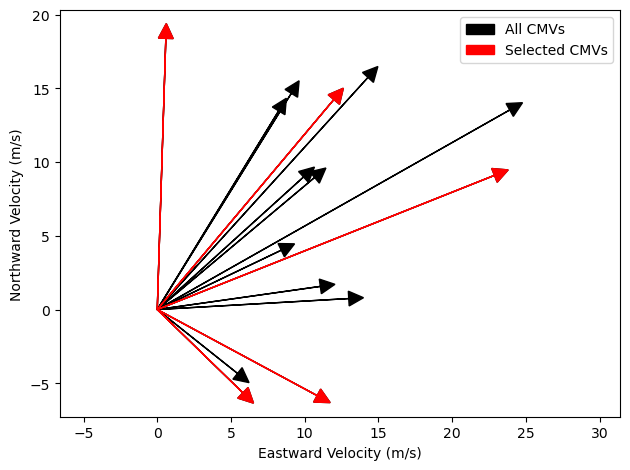

In [11]:
# Plot the vectors visually
plt.figure()
for i, (dx, dy) in enumerate(zip(vx, vy)):
    mylabel = 'All CMVs' if i == 0 else '_nolegend_'
    plt.arrow(0, 0, dx, dy, head_width=1, head_length=1, fc='k', label=mylabel)
for i, (dx, dy) in enumerate(zip(vx.iloc[indices], vy.iloc[indices])):
    mylabel = 'Selected CMVs' if i == 0 else '_nolegend_'
    plt.arrow(0, 0, dx, dy, head_width=1, head_length=1, fc='r', ec='r', label=mylabel)
plt.xlabel('Eastward Velocity (m/s)')
plt.ylabel('Northward Velocity (m/s)')
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()